In [1]:
# SKIP THIS IF YOU WANT TO USE THE NON WEB INTERFACE (can only be done when notebook run locally)
%matplotlib inline


In [8]:
try:
    %load_ext autoreload
    %autoreload 2
    
except:
    print 'NOT IPYTHON'

import sys
import numpy as np
#sys.path.append('../SPGL1_python_port')
import ca_source_extraction as cse
#%
from matplotlib import pyplot as plt
from time import time
from scipy.sparse import coo_matrix
import tifffile
import subprocess
import time as tm
import pylab as pl
from time import time
#% for caching
import psutil

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
#import bokeh.plotting as bp
import bokeh.plotting as bpl
from bokeh.io import vform,hplot,vplot,gridplot
from bokeh.models import CustomJS, ColumnDataSource, Slider
from IPython.display import display, clear_output
import matplotlib as mpl
import matplotlib.cm as cm
import numpy as np

bpl.output_notebook()

BokehJS successfully loaded.

In [10]:
n_processes = np.maximum(psutil.cpu_count() - 2,1) # roughly number of cores on your machine minus 1
#print 'using ' + str(n_processes) + ' processes'
p=2 # order of the AR model (in general 1 or 2)


In [11]:
#%% start cluster for efficient computation
print "Stopping  cluster to avoid unnencessary use of memory...."
sys.stdout.flush()  
cse.utilities.stop_server()

Stopping  cluster to avoid unnencessary use of memory....
Stopping cluster...
No cluster to stop... done


In [12]:
reload=0
filename='movies/demoMovie.tif'
t = tifffile.TiffFile(filename) 
Yr = t.asarray().astype(dtype=np.float32) 
Yr = np.transpose(Yr,(1,2,0))
d1,d2,T=Yr.shape
Yr=np.reshape(Yr,(d1*d2,T),order='F')
#np.save('Y',Y)
np.save('Yr',Yr)
#Y=np.load('Y.npy',mmap_mode='r')
Yr=np.load('Yr.npy',mmap_mode='r')        
Y=np.reshape(Yr,(d1,d2,T),order='F')
Cn = cse.utilities.local_correlations(Y)

In [13]:
#%%
options = cse.utilities.CNMFSetParms(Y,p=p,gSig=[4,4],K=30)
cse.utilities.start_server(options['spatial_params']['n_processes'])

using 22 processes
Starting cluster..................... done


In [14]:
t1 = time()
Yr,sn,g=cse.pre_processing.preprocess_data(Yr,**options['preprocess_params'])
Atmp, Ctmp, b_in, f_in, center=cse.initialization.initialize_components(Y, **options['init_params'])                                                    
print time() - t1 
clear_output(wait=True)
print('DONE!')

DONE!


In [15]:
refine_components=False
if refine_components:
    Ain,Cin = cse.utilities.manually_refine_components(Y,options['init_params']['gSig'],coo_matrix(Atmp),Ctmp,Cn,thr=0.9)
else:
    Ain,Cin = Atmp, Ctmp

In [16]:
p=cse.nb_plot_contour(Cn,Ain,d1,d2,thr=0.9,face_color=None, line_color='black',alpha=0.4,line_width=2)
bpl.show(p)

In [17]:
#%%
t1 = time()
A,b,Cin = cse.spatial.update_spatial_components(Yr, Cin, f_in, Ain, sn=sn, **options['spatial_params'])
t_elSPATIAL = time() - t1
print t_elSPATIAL 
#clear_output(wait=True)
print('DONE!')

 find search location
Updated Spatial Components
threshold
Computing A_bas
--- 3.02873897552 seconds ---
Remove temporary file created
3.03279709816
DONE!


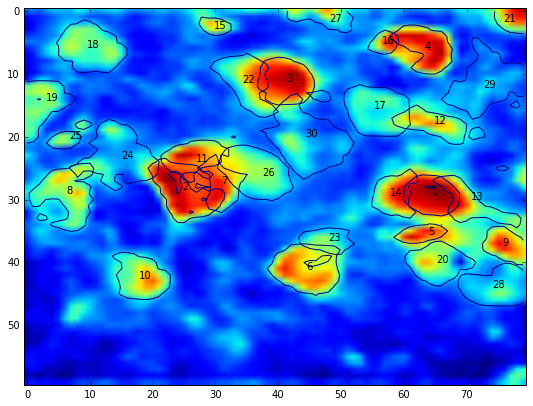

In [18]:
plt.figure(num=None, figsize=(9, 7), dpi=100, facecolor='w', edgecolor='k')
crd = cse.utilities.plot_contours(A,Cn,thr=0.9)
plt.show()

In [19]:
p=cse.nb_plot_contour(Cn,A.todense(),d1,d2,thr=0.9,face_color=None, line_color='black',alpha=0.4,line_width=2)
bpl.show(p)

In [20]:
#%% update_temporal_components
t1 = time()
C,f,S,bl,c1,neurons_sn,g,YrA = cse.temporal.update_temporal_components(Yr,A,b,Cin,f_in,bl=None,c1=None,sn=None,g=None,**options['temporal_params'])
t_elTEMPORAL2 = time() - t1
clear_output(wait=True)
print('DONE!')
print t_elTEMPORAL2   

DONE!
3.39349293709


In [21]:
#%% merge components corresponding to the same neuron
t1 = time()
A_m,C_m,nr_m,merged_ROIs,S_m,bl_m,c1_m,sn_m,g_m=cse.merging.merge_components(Yr,A,b,C,f,S,sn,options['temporal_params'], options['spatial_params'], bl=bl, c1=c1, sn=neurons_sn, g=g, thr=0.8, mx=50, fast_merge = True)
t_elMERGE = time() - t1
clear_output(wait=True)
print('DONE!')
print t_elMERGE  

DONE!
2.15347599983


In [22]:
#refine spatial and temporal components
t1 = time()
A2,b2,C2 = cse.spatial.update_spatial_components(Yr, C_m, f, A_m, sn=sn, **options['spatial_params'])
#C2,f2,Y_res2,S2,bl2,c12,neurons_sn2,g21 = cse.update_temporal_components_parallel(Yr,A2,b2,C2,f,bl=bl_m,c1=c1_m,sn=sn_m,g=g_m,**temporal_params)
C2,f2,S2,bl2,c12,neurons_sn2,g21,YrA = cse.temporal.update_temporal_components(Yr,A2,b2,C2,f,bl=None,c1=None,sn=None,g=None,**options['temporal_params'])
print time() - t1
clear_output(wait=True)
print time() - t1 # 100 seconds
print('DONE!')

6.40900683403
DONE!


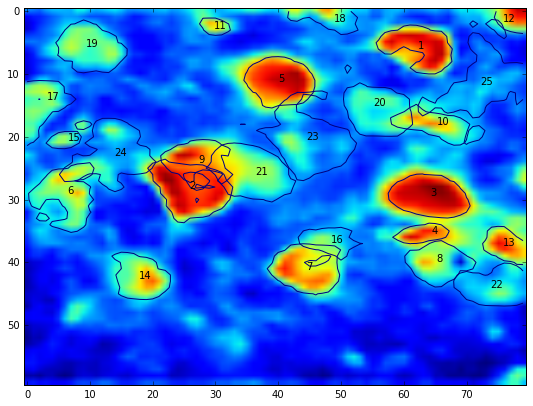

In [23]:
plt.figure(num=None, figsize=(9, 7), dpi=100, facecolor='w', edgecolor='k')
A_or, C_or, srt = cse.utilities.order_components(A2,C2)
crd = cse.utilities.plot_contours(coo_matrix(A_or),Cn,thr=0.9)
plt.show()

In [24]:
p=cse.utilities.nb_plot_contour(Cn,A_or,d1,d2,thr=0.9,face_color='purple', line_color='black',alpha=0.3,line_width=2)
bpl.show(p)

In [26]:
traces_fluo=cse.utilities.nb_view_patches(Yr,A_or,C_or,b2,f2,d1,d2,thr = 0.9)

BokehJS successfully loaded.

In [27]:
#%% STOP CLUSTER
cse.utilities.stop_server()

Stopping cluster...
Waiting for cluster to stop....... done
